# FNN for forecast without features

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
import torch
import torch.nn as nn
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from xgboost import XGBRegressor

np.random.seed(0)
torch.random.manual_seed(0)
torch.cuda.random.manual_seed(0)
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"
device = torch.device(dev)

## load data

In [2]:
url = '../data/beijing.csv'
data = pd.read_csv(url, sep=',', index_col='time')
data = data[['load']]

## normalization

In [3]:
def normalization(data):
    """
    data: original data with load
    return: normalized data, scaler of load
    """
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data)
    scaler_y = MinMaxScaler()
    scaler_y.fit_transform(data[[data.columns[-1]]])
    return normalized_data, scaler, scaler_y

## build supervised dataset

In [4]:
def Series_To_Supervise(data, seq_len, target_len):
    """
    convert series data to supervised data
    :param data: original data
    :param seq_len: length of input sequence
    :param target_len: length of ouput sequence
    :return: return two ndarrays-- input and output in format suitable to feed to LSTM
    """
    dim_0 = data.shape[0] - seq_len - target_len + 1
    dim_1 = data.shape[1]
    x = np.zeros((dim_0, seq_len, dim_1))
    y = np.zeros((dim_0, target_len))
    for i in range(dim_0):
        x[i] = data[i:i + seq_len]
        y[i] = data[i + seq_len:i + seq_len + target_len, -1]
    print("Supervised Data: Shape of x: {}, Shape of y: {}".format(x.shape, y.shape))
    return x, y

## feature seletion

In [5]:
def select_feature(X, Y, feature_num=100):
    """
    X: features
    Y: labels
    feature_num: num of selected features
    return: index of selected features
    """
    X = X.reshape(X.shape[0], -1)
    model = XGBRegressor()
    model.fit(X, Y)
    model.importance_type = 'weight'
    ind = (-model.feature_importances_).argsort()[0:feature_num]
    return ind

## 5-folds TimeSeriesSplit

In [6]:
def time_series_split(X, Y, n_split=5):
    """
    X: features, size * seq_len * feature_num
    Y: labels, size * target_len
    return: list of train_x, test_x, train_y, test_y
    """
    tscv = TimeSeriesSplit(n_splits=n_split)
    train_x_list = list()
    valid_x_list = list()
    train_y_list = list()
    valid_y_list = list()
    for train_index, valid_index in tscv.split(X):
        train_x_list.append(X[train_index])
        train_y_list.append(Y[train_index])
        valid_x_list.append(X[valid_index])
        valid_y_list.append(Y[valid_index])
    return train_x_list, train_y_list, valid_x_list, valid_y_list

## model define

In [7]:
class FNN(nn.Module):
    """
    A fnn neural network
    """
    def __init__(self, input_size, output_size, hidden_dim, drop_prob):
        super(FNN, self).__init__()

        self.fnn = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, hidden_dim),
            nn.ReLU(),
            nn.Dropout(drop_prob),
            nn.Linear(hidden_dim, output_size),
        )

    def forward(self, x):
        out = self.fnn(x)
        return out

## model training for  hyper-parameters optimization

In [8]:
def train_model_hpo(train_x_list, train_y_list, valid_x_list, valid_y_list,
                    input_size, output_size, mse_thresh, batch_size, lr,
                    number_epoch, hidden_dim, drop_prob, weight_decay):
    valid_loss_list = []
    for num in range(len(train_x_list)):
        while (1):
            model_fnn = FNN(input_size, output_size, hidden_dim, drop_prob)
            model_fnn.to(device=device)
            criterion = nn.MSELoss()
            optimizer = torch.optim.Adam(model_fnn.parameters(), lr=lr, weight_decay=weight_decay)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                        step_size=1,
                                                        gamma=0.98)
            valid_loss_min = np.Inf
            print('cross-validation dataset {}'.format(num))
            train_x = train_x_list[num]
            train_y = train_y_list[num]
            valid_x = valid_x_list[num]
            valid_y = valid_y_list[num]
            train_dataset = TensorDataset(torch.FloatTensor(train_x),
                                          torch.FloatTensor(train_y))
            valid_dataset = TensorDataset(torch.FloatTensor(valid_x),
                                          torch.FloatTensor(valid_y))
            train_loader = DataLoader(dataset=train_dataset,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      drop_last=False)
            valid_loader = DataLoader(dataset=valid_dataset,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      drop_last=False)
            num_without_imp = 0
            # training process
            for epoch in range(1, number_epoch + 1):
                loop = tqdm(enumerate(train_loader),
                            total=len(train_loader),
                            leave=True)
                for i, (inputs, labels) in loop:
                    inputs = inputs.to(device=device)
                    labels = labels.to(device=device)
                    optimizer.zero_grad()
                    outputs = model_fnn(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    if i % 5 == 0:
                        num_without_imp = num_without_imp + 1
                        valid_losses = list()
                        model_fnn.eval()
                        for inp, lab in valid_loader:
                            inp = inp.to(device)
                            lab = lab.to(device)
                            out = model_fnn(inp)
                            valid_loss = criterion(out, lab)
                            valid_losses.append(valid_loss.item())

                        model_fnn.train()
                        loop.set_description("Epoch: {}/{}".format(
                            epoch, number_epoch))
                        loop.set_postfix(train_loss=loss.item(),
                                         valid_loss=np.mean(valid_losses))
                        if np.mean(valid_losses) < valid_loss_min:
                            num_without_imp = 0
                            valid_loss_min = np.mean(valid_losses)
                scheduler.step()
                if num_without_imp >= 80:
                    break
            if valid_loss_min < mse_thresh:
                valid_loss_list.append(valid_loss_min)
                break
    return np.mean(valid_loss_list)

## hyper-parameters config

In [9]:
seq_len = 72
target_len = 24
feature_num = 100
mse_thresh = 0.01


def model_config():
    batch_sizes = [256, 128, 512]
    lrs = [0.005, 0.001, 0.01]
    number_epochs = [50]
    hidden_dims = [35, 30, 25]
    drop_probs = [0.1]
    weight_decays = [1e-7]
    configs = list()
    for i in batch_sizes:
        for j in lrs:
            for k in number_epochs:
                for l in hidden_dims:
                    for m in drop_probs:
                        for n in weight_decays:
                            configs.append({
                                'batch_size': i,
                                'lr': j,
                                'number_epoch': k,
                                'hidden_dim': l,
                                'drop_prob': m,
                                'weight_decay': n
                            })
    return configs

## random search for HPO

In [10]:
def run_model_hpo(seq_len=seq_len,
                  target_len=target_len,
                  feature_num=feature_num,
                  mse_thresh=mse_thresh):
    train_data = data[:int(0.7 * len(data))]
    train_data, _, _ = normalization(train_data)
    train_x, train_y = Series_To_Supervise(train_data, seq_len, target_len)
    #     ind = select_feature(train_x, train_y, feature_num=feature_num)
#     train_x = train_x.reshape(train_x.shape[0], -1)
    train_x_list, train_y_list, valid_x_list, valid_y_list = time_series_split(
        train_x, train_y)
#     with enough data
#     train_x_list = train_x_list[-1:]
#     train_y_list = train_y_list[-1:]
#     valid_x_list = valid_x_list[-1:]
#     valid_y_list = valid_y_list[-1:]
    
    configs = model_config()
    records = []
    input_size = train_x.shape[1]
    output_size = target_len
    for i in range(20):
        config = random.choice(configs)
        configs.remove(config)
        batch_size = config['batch_size']
        lr = config['lr']
        number_epoch = config['number_epoch']
        hidden_dim = config['hidden_dim']
        drop_prob = config['drop_prob']
        weight_decay = config['weight_decay']
        print(
            "model config: batch_size--{}, lr--{}, number_epoch--{}, hidden_dim--{},drop_prob-{},weight_decay-{}"
            .format(batch_size, lr, number_epoch, hidden_dim, drop_prob, weight_decay))
        valid_loss = train_model_hpo(train_x_list, train_y_list, valid_x_list,
                                     valid_y_list, input_size, output_size,
                                     mse_thresh, batch_size, lr, number_epoch,
                                     hidden_dim, drop_prob, weight_decay)
        records.append({
            'batch_size': batch_size,
            'lr': lr,
            'number_epoch': number_epoch,
            'hidden_dim': hidden_dim,
            'drop_prob': drop_prob,
            'weight_decay': weight_decay,
            'valid_loss': valid_loss
        })
    return records

## run random search

In [11]:
records = run_model_hpo()

Supervised Data: Shape of x: (22066, 72, 1), Shape of y: (22066, 24)
model config: batch_size--128, lr--0.005, number_epoch--50, hidden_dim--25,drop_prob-0.1,weight_decay-1e-07
cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 29/29 [00:00<00:00, 129.00it/s, train_loss=0.00224, valid_loss=0.00478]


cross-validation dataset 1


Epoch: 18/50: 100%|██████████| 58/58 [00:00<00:00, 127.71it/s, train_loss=0.00449, valid_loss=0.00288]


cross-validation dataset 2


Epoch: 26/50: 100%|██████████| 87/87 [00:00<00:00, 129.78it/s, train_loss=0.00508, valid_loss=0.00414]


cross-validation dataset 3


Epoch: 9/50: 100%|██████████| 115/115 [00:00<00:00, 139.72it/s, train_loss=0.00553, valid_loss=0.00274]


cross-validation dataset 4


Epoch: 25/50: 100%|██████████| 144/144 [00:01<00:00, 134.32it/s, train_loss=0.00373, valid_loss=0.00215]


model config: batch_size--512, lr--0.005, number_epoch--50, hidden_dim--25,drop_prob-0.1,weight_decay-1e-07
cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 97.54it/s, train_loss=0.0114, valid_loss=0.0174]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 127.18it/s, train_loss=0.00313, valid_loss=0.00447]


cross-validation dataset 1


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 142.64it/s, train_loss=0.0103, valid_loss=0.011]


cross-validation dataset 1


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 91.94it/s, train_loss=0.00401, valid_loss=0.00397]


cross-validation dataset 2


Epoch: 50/50: 100%|██████████| 22/22 [00:00<00:00, 133.51it/s, train_loss=0.00995, valid_loss=0.0112]


cross-validation dataset 2


Epoch: 43/50: 100%|██████████| 22/22 [00:00<00:00, 133.25it/s, train_loss=0.0042, valid_loss=0.00472] 


cross-validation dataset 3


Epoch: 36/50: 100%|██████████| 29/29 [00:00<00:00, 123.55it/s, train_loss=0.00407, valid_loss=0.00288]


cross-validation dataset 4


Epoch: 50/50: 100%|██████████| 36/36 [00:00<00:00, 132.40it/s, train_loss=0.00389, valid_loss=0.00262]


model config: batch_size--128, lr--0.001, number_epoch--50, hidden_dim--25,drop_prob-0.1,weight_decay-1e-07
cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 29/29 [00:00<00:00, 130.80it/s, train_loss=0.00278, valid_loss=0.00439]


cross-validation dataset 1


Epoch: 29/50: 100%|██████████| 58/58 [00:00<00:00, 127.68it/s, train_loss=0.00392, valid_loss=0.0023] 


cross-validation dataset 2


Epoch: 50/50: 100%|██████████| 87/87 [00:00<00:00, 122.38it/s, train_loss=0.0104, valid_loss=0.0109] 


cross-validation dataset 2


Epoch: 46/50: 100%|██████████| 87/87 [00:00<00:00, 131.89it/s, train_loss=0.00377, valid_loss=0.00323]


cross-validation dataset 3


Epoch: 28/50: 100%|██████████| 115/115 [00:00<00:00, 135.40it/s, train_loss=0.0102, valid_loss=0.0109]


cross-validation dataset 3


Epoch: 13/50: 100%|██████████| 115/115 [00:00<00:00, 129.55it/s, train_loss=0.00513, valid_loss=0.00214]


cross-validation dataset 4


Epoch: 38/50: 100%|██████████| 144/144 [00:01<00:00, 122.53it/s, train_loss=0.011, valid_loss=0.0077]   


model config: batch_size--128, lr--0.005, number_epoch--50, hidden_dim--35,drop_prob-0.1,weight_decay-1e-07
cross-validation dataset 0


Epoch: 36/50: 100%|██████████| 29/29 [00:00<00:00, 136.52it/s, train_loss=0.00256, valid_loss=0.00492]


cross-validation dataset 1


Epoch: 33/50: 100%|██████████| 58/58 [00:00<00:00, 126.08it/s, train_loss=0.00317, valid_loss=0.00289]


cross-validation dataset 2


Epoch: 37/50: 100%|██████████| 87/87 [00:00<00:00, 125.09it/s, train_loss=0.00308, valid_loss=0.00321]


cross-validation dataset 3


Epoch: 11/50: 100%|██████████| 115/115 [00:00<00:00, 131.63it/s, train_loss=0.00403, valid_loss=0.00215]


cross-validation dataset 4


Epoch: 14/50: 100%|██████████| 144/144 [00:01<00:00, 118.77it/s, train_loss=0.00423, valid_loss=0.00287]


model config: batch_size--512, lr--0.01, number_epoch--50, hidden_dim--30,drop_prob-0.1,weight_decay-1e-07
cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 126.64it/s, train_loss=0.00294, valid_loss=0.00491]


cross-validation dataset 1


Epoch: 43/50: 100%|██████████| 15/15 [00:00<00:00, 141.22it/s, train_loss=0.00428, valid_loss=0.00235]


cross-validation dataset 2


Epoch: 50/50: 100%|██████████| 22/22 [00:00<00:00, 127.72it/s, train_loss=0.00339, valid_loss=0.00381]


cross-validation dataset 3


Epoch: 29/50: 100%|██████████| 29/29 [00:00<00:00, 133.90it/s, train_loss=0.00449, valid_loss=0.00288]


cross-validation dataset 4


Epoch: 39/50: 100%|██████████| 36/36 [00:00<00:00, 137.48it/s, train_loss=0.00458, valid_loss=0.0026] 


model config: batch_size--512, lr--0.001, number_epoch--50, hidden_dim--25,drop_prob-0.1,weight_decay-1e-07
cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 98.53it/s, train_loss=0.0133, valid_loss=0.0182]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 114.55it/s, train_loss=0.0133, valid_loss=0.0182]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 117.03it/s, train_loss=0.00936, valid_loss=0.0129]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 117.09it/s, train_loss=0.00535, valid_loss=0.00656]


cross-validation dataset 1


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 144.33it/s, train_loss=0.00574, valid_loss=0.00262]


cross-validation dataset 2


Epoch: 50/50: 100%|██████████| 22/22 [00:00<00:00, 134.94it/s, train_loss=0.00528, valid_loss=0.00367]


cross-validation dataset 3


Epoch: 50/50: 100%|██████████| 29/29 [00:00<00:00, 132.80it/s, train_loss=0.0111, valid_loss=0.0108]


cross-validation dataset 3


Epoch: 50/50: 100%|██████████| 29/29 [00:00<00:00, 142.03it/s, train_loss=0.00487, valid_loss=0.00202]


cross-validation dataset 4


Epoch: 50/50: 100%|██████████| 36/36 [00:00<00:00, 117.85it/s, train_loss=0.0117, valid_loss=0.00799]


model config: batch_size--256, lr--0.001, number_epoch--50, hidden_dim--30,drop_prob-0.1,weight_decay-1e-07
cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 158.26it/s, train_loss=0.00314, valid_loss=0.00481]


cross-validation dataset 1


Epoch: 47/50: 100%|██████████| 29/29 [00:00<00:00, 153.28it/s, train_loss=0.00435, valid_loss=0.00191]


cross-validation dataset 2


Epoch: 50/50: 100%|██████████| 44/44 [00:00<00:00, 154.59it/s, train_loss=0.0101, valid_loss=0.0109]


cross-validation dataset 2


Epoch: 50/50: 100%|██████████| 44/44 [00:00<00:00, 145.20it/s, train_loss=0.00405, valid_loss=0.00344]


cross-validation dataset 3


Epoch: 37/50: 100%|██████████| 58/58 [00:00<00:00, 131.59it/s, train_loss=0.00429, valid_loss=0.00159]


cross-validation dataset 4


Epoch: 50/50: 100%|██████████| 72/72 [00:00<00:00, 135.74it/s, train_loss=0.0039, valid_loss=0.00218] 


model config: batch_size--256, lr--0.001, number_epoch--50, hidden_dim--35,drop_prob-0.1,weight_decay-1e-07
cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 127.29it/s, train_loss=0.00331, valid_loss=0.00465]


cross-validation dataset 1


Epoch: 45/50: 100%|██████████| 29/29 [00:00<00:00, 151.07it/s, train_loss=0.00479, valid_loss=0.002]  


cross-validation dataset 2


Epoch: 50/50: 100%|██████████| 44/44 [00:00<00:00, 131.46it/s, train_loss=0.00431, valid_loss=0.00351]


cross-validation dataset 3


Epoch: 25/50: 100%|██████████| 58/58 [00:00<00:00, 127.74it/s, train_loss=0.00432, valid_loss=0.0028] 


cross-validation dataset 4


Epoch: 34/50: 100%|██████████| 72/72 [00:00<00:00, 134.86it/s, train_loss=0.00397, valid_loss=0.00217]


model config: batch_size--128, lr--0.01, number_epoch--50, hidden_dim--25,drop_prob-0.1,weight_decay-1e-07
cross-validation dataset 0


Epoch: 37/50: 100%|██████████| 29/29 [00:00<00:00, 104.98it/s, train_loss=0.00238, valid_loss=0.00504]


cross-validation dataset 1


Epoch: 26/50: 100%|██████████| 58/58 [00:00<00:00, 142.01it/s, train_loss=0.00381, valid_loss=0.00274]


cross-validation dataset 2


Epoch: 16/50: 100%|██████████| 87/87 [00:00<00:00, 142.14it/s, train_loss=0.00484, valid_loss=0.00368]


cross-validation dataset 3


Epoch: 18/50: 100%|██████████| 115/115 [00:00<00:00, 146.33it/s, train_loss=0.0051, valid_loss=0.00462] 


cross-validation dataset 4


Epoch: 16/50: 100%|██████████| 144/144 [00:01<00:00, 143.60it/s, train_loss=0.00463, valid_loss=0.00271]


model config: batch_size--256, lr--0.01, number_epoch--50, hidden_dim--35,drop_prob-0.1,weight_decay-1e-07
cross-validation dataset 0


Epoch: 46/50: 100%|██████████| 15/15 [00:00<00:00, 156.19it/s, train_loss=0.00255, valid_loss=0.00472]


cross-validation dataset 1


Epoch: 24/50: 100%|██████████| 29/29 [00:00<00:00, 152.19it/s, train_loss=0.00379, valid_loss=0.0027] 


cross-validation dataset 2


Epoch: 28/50: 100%|██████████| 44/44 [00:00<00:00, 153.76it/s, train_loss=0.00345, valid_loss=0.00466]


cross-validation dataset 3


Epoch: 15/50: 100%|██████████| 58/58 [00:00<00:00, 133.50it/s, train_loss=0.00474, valid_loss=0.00257]


cross-validation dataset 4


Epoch: 34/50: 100%|██████████| 72/72 [00:00<00:00, 132.85it/s, train_loss=0.00385, valid_loss=0.00229]


model config: batch_size--128, lr--0.01, number_epoch--50, hidden_dim--35,drop_prob-0.1,weight_decay-1e-07
cross-validation dataset 0


Epoch: 32/50: 100%|██████████| 29/29 [00:00<00:00, 135.33it/s, train_loss=0.00229, valid_loss=0.00456]


cross-validation dataset 1


Epoch: 17/50: 100%|██████████| 58/58 [00:00<00:00, 113.01it/s, train_loss=0.00495, valid_loss=0.00514]


cross-validation dataset 2


Epoch: 17/50: 100%|██████████| 87/87 [00:00<00:00, 150.95it/s, train_loss=0.00361, valid_loss=0.00333]


cross-validation dataset 3


Epoch: 19/50: 100%|██████████| 115/115 [00:00<00:00, 130.77it/s, train_loss=0.00415, valid_loss=0.00287]


cross-validation dataset 4


Epoch: 10/50: 100%|██████████| 144/144 [00:01<00:00, 129.97it/s, train_loss=0.00405, valid_loss=0.00228]


model config: batch_size--128, lr--0.005, number_epoch--50, hidden_dim--30,drop_prob-0.1,weight_decay-1e-07
cross-validation dataset 0


Epoch: 37/50: 100%|██████████| 29/29 [00:00<00:00, 140.05it/s, train_loss=0.00268, valid_loss=0.00537]


cross-validation dataset 1


Epoch: 18/50: 100%|██████████| 58/58 [00:00<00:00, 141.87it/s, train_loss=0.00381, valid_loss=0.00361]


cross-validation dataset 2


Epoch: 16/50: 100%|██████████| 87/87 [00:00<00:00, 142.47it/s, train_loss=0.00363, valid_loss=0.00403]


cross-validation dataset 3


Epoch: 12/50: 100%|██████████| 115/115 [00:00<00:00, 146.79it/s, train_loss=0.00455, valid_loss=0.00191]


cross-validation dataset 4


Epoch: 10/50: 100%|██████████| 144/144 [00:00<00:00, 146.08it/s, train_loss=0.00504, valid_loss=0.00306]


model config: batch_size--512, lr--0.001, number_epoch--50, hidden_dim--30,drop_prob-0.1,weight_decay-1e-07
cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 131.08it/s, train_loss=0.00536, valid_loss=0.00641]


cross-validation dataset 1


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 141.35it/s, train_loss=0.00579, valid_loss=0.00258]


cross-validation dataset 2


Epoch: 50/50: 100%|██████████| 22/22 [00:00<00:00, 135.36it/s, train_loss=0.011, valid_loss=0.0114] 


cross-validation dataset 2


Epoch: 50/50: 100%|██████████| 22/22 [00:00<00:00, 134.40it/s, train_loss=0.00494, valid_loss=0.00342]


cross-validation dataset 3


Epoch: 50/50: 100%|██████████| 29/29 [00:00<00:00, 139.08it/s, train_loss=0.00475, valid_loss=0.00192]


cross-validation dataset 4


Epoch: 50/50: 100%|██████████| 36/36 [00:00<00:00, 119.88it/s, train_loss=0.00422, valid_loss=0.00234]


model config: batch_size--512, lr--0.005, number_epoch--50, hidden_dim--35,drop_prob-0.1,weight_decay-1e-07
cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 127.80it/s, train_loss=0.00367, valid_loss=0.0052]


cross-validation dataset 1


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 110.69it/s, train_loss=0.00353, valid_loss=0.00243]


cross-validation dataset 2


Epoch: 50/50: 100%|██████████| 22/22 [00:00<00:00, 110.06it/s, train_loss=0.00353, valid_loss=0.00411]


cross-validation dataset 3


Epoch: 28/50: 100%|██████████| 29/29 [00:00<00:00, 130.06it/s, train_loss=0.00344, valid_loss=0.00191]


cross-validation dataset 4


Epoch: 38/50: 100%|██████████| 36/36 [00:00<00:00, 112.09it/s, train_loss=0.0037, valid_loss=0.00238] 


model config: batch_size--256, lr--0.01, number_epoch--50, hidden_dim--25,drop_prob-0.1,weight_decay-1e-07
cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 156.48it/s, train_loss=0.00344, valid_loss=0.00494]


cross-validation dataset 1


Epoch: 32/50: 100%|██████████| 29/29 [00:00<00:00, 145.30it/s, train_loss=0.00394, valid_loss=0.00403]


cross-validation dataset 2


Epoch: 30/50: 100%|██████████| 44/44 [00:00<00:00, 154.57it/s, train_loss=0.00445, valid_loss=0.00412]


cross-validation dataset 3


Epoch: 28/50: 100%|██████████| 58/58 [00:00<00:00, 137.75it/s, train_loss=0.00545, valid_loss=0.00394]


cross-validation dataset 4


Epoch: 19/50: 100%|██████████| 72/72 [00:00<00:00, 139.76it/s, train_loss=0.00512, valid_loss=0.00288]


model config: batch_size--512, lr--0.005, number_epoch--50, hidden_dim--30,drop_prob-0.1,weight_decay-1e-07
cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 130.74it/s, train_loss=0.00728, valid_loss=0.0108]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 128.98it/s, train_loss=0.00303, valid_loss=0.00489]


cross-validation dataset 1


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 142.67it/s, train_loss=0.00406, valid_loss=0.00264]


cross-validation dataset 2


Epoch: 47/50: 100%|██████████| 22/22 [00:00<00:00, 134.69it/s, train_loss=0.0102, valid_loss=0.011]  


cross-validation dataset 2


Epoch: 33/50: 100%|██████████| 22/22 [00:00<00:00, 109.08it/s, train_loss=0.00442, valid_loss=0.00448]


cross-validation dataset 3


Epoch: 27/50: 100%|██████████| 29/29 [00:00<00:00, 140.10it/s, train_loss=0.00427, valid_loss=0.00286]


cross-validation dataset 4


Epoch: 44/50: 100%|██████████| 36/36 [00:00<00:00, 127.86it/s, train_loss=0.00415, valid_loss=0.00309]


model config: batch_size--512, lr--0.01, number_epoch--50, hidden_dim--35,drop_prob-0.1,weight_decay-1e-07
cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 103.20it/s, train_loss=0.00292, valid_loss=0.00543]


cross-validation dataset 1


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 123.31it/s, train_loss=0.00414, valid_loss=0.00301]


cross-validation dataset 2


Epoch: 38/50: 100%|██████████| 22/22 [00:00<00:00, 133.91it/s, train_loss=0.00426, valid_loss=0.0041] 


cross-validation dataset 3


Epoch: 40/50: 100%|██████████| 29/29 [00:00<00:00, 137.94it/s, train_loss=0.00405, valid_loss=0.00296]


cross-validation dataset 4


Epoch: 39/50: 100%|██████████| 36/36 [00:00<00:00, 121.25it/s, train_loss=0.00371, valid_loss=0.00245]


model config: batch_size--512, lr--0.001, number_epoch--50, hidden_dim--35,drop_prob-0.1,weight_decay-1e-07
cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 99.31it/s, train_loss=0.0127, valid_loss=0.0179]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 76.55it/s, train_loss=0.0129, valid_loss=0.0182]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 97.36it/s, train_loss=0.00905, valid_loss=0.0127]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 8/8 [00:00<00:00, 124.66it/s, train_loss=0.00405, valid_loss=0.00567]


cross-validation dataset 1


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 143.63it/s, train_loss=0.00554, valid_loss=0.00307]


cross-validation dataset 2


Epoch: 50/50: 100%|██████████| 22/22 [00:00<00:00, 135.01it/s, train_loss=0.00432, valid_loss=0.00349]


cross-validation dataset 3


Epoch: 50/50: 100%|██████████| 29/29 [00:00<00:00, 141.93it/s, train_loss=0.00499, valid_loss=0.0019] 


cross-validation dataset 4


Epoch: 50/50: 100%|██████████| 36/36 [00:00<00:00, 136.33it/s, train_loss=0.00461, valid_loss=0.00226]


model config: batch_size--256, lr--0.005, number_epoch--50, hidden_dim--30,drop_prob-0.1,weight_decay-1e-07
cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 132.94it/s, train_loss=0.00268, valid_loss=0.00439]


cross-validation dataset 1


Epoch: 24/50: 100%|██████████| 29/29 [00:00<00:00, 124.35it/s, train_loss=0.00448, valid_loss=0.00365]


cross-validation dataset 2


Epoch: 38/50: 100%|██████████| 44/44 [00:00<00:00, 153.28it/s, train_loss=0.00433, valid_loss=0.00372]


cross-validation dataset 3


Epoch: 17/50: 100%|██████████| 58/58 [00:00<00:00, 152.73it/s, train_loss=0.00405, valid_loss=0.00262]


cross-validation dataset 4


Epoch: 31/50: 100%|██████████| 72/72 [00:00<00:00, 142.42it/s, train_loss=0.00388, valid_loss=0.00244]


model config: batch_size--256, lr--0.005, number_epoch--50, hidden_dim--25,drop_prob-0.1,weight_decay-1e-07
cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 154.05it/s, train_loss=0.00704, valid_loss=0.0113]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 155.57it/s, train_loss=0.00642, valid_loss=0.0111]


cross-validation dataset 0


Epoch: 50/50: 100%|██████████| 15/15 [00:00<00:00, 155.84it/s, train_loss=0.00273, valid_loss=0.00484]


cross-validation dataset 1


Epoch: 41/50: 100%|██████████| 29/29 [00:00<00:00, 135.52it/s, train_loss=0.00364, valid_loss=0.00193]


cross-validation dataset 2


Epoch: 36/50: 100%|██████████| 44/44 [00:00<00:00, 122.74it/s, train_loss=0.00365, valid_loss=0.00384]


cross-validation dataset 3


Epoch: 22/50: 100%|██████████| 58/58 [00:00<00:00, 109.96it/s, train_loss=0.00496, valid_loss=0.00446]


cross-validation dataset 4


Epoch: 22/50: 100%|██████████| 72/72 [00:00<00:00, 133.71it/s, train_loss=0.00386, valid_loss=0.00257]


## find the best hyper-parameters

In [12]:
records = pd.DataFrame(records).sort_values(by='valid_loss')
records.to_csv('./records/fnn_records_without_features.csv', mode='a', index=False, header=False)
records

,batch_size,lr,number_epoch,hidden_dim,drop_prob,weight_decay,valid_loss
3,128,0.005,50,35,0.1,1.000000e-07,0.002603
18,256,0.005,50,30,0.1,1.000000e-07,0.002615
7,256,0.001,50,35,0.1,1.000000e-07,0.002667
6,256,0.001,50,30,0.1,1.000000e-07,0.002679
10,128,0.010,50,35,0.1,1.000000e-07,0.002695
9,256,0.010,50,35,0.1,1.000000e-07,0.002718
11,128,0.005,50,30,0.1,1.000000e-07,0.002790
0,128,0.005,50,25,0.1,1.000000e-07,0.002811
16,512,0.010,50,35,0.1,1.000000e-07,0.002822
4,512,0.010,50,30,0.1,1.000000e-07,0.002827


## retrain a model

In [11]:
def train_model(train_x, train_y, valid_x, valid_y, input_size, output_size,
                mse_thresh, batch_size, lr, number_epoch, hidden_dim,
                drop_prob, weight_decay):
    while (1):
        model_fnn = FNN(input_size, output_size, hidden_dim, drop_prob)
        model_fnn.to(device=device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model_fnn.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.98)
        valid_loss_min = np.Inf
        train_dataset = TensorDataset(torch.FloatTensor(train_x),
                                      torch.FloatTensor(train_y))
        valid_dataset = TensorDataset(torch.FloatTensor(valid_x),
                                      torch.FloatTensor(valid_y))
        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  drop_last=False)
        valid_loader = DataLoader(dataset=valid_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  drop_last=False)
        num_without_imp = 0
        train_loss_list = []
        valid_loss_list = []
        # training process
        for epoch in range(1, number_epoch + 1):
            loop = tqdm(enumerate(train_loader),
                        total=len(train_loader),
                        leave=True)
            for i, (inputs, labels) in loop:
                inputs = inputs.to(device=device)
                labels = labels.to(device=device)
                optimizer.zero_grad()
                outputs = model_fnn(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                if i % 5 == 0:
                    num_without_imp = num_without_imp + 1
                    valid_losses = list()
                    model_fnn.eval()
                    for inp, lab in valid_loader:
                        inp = inp.to(device)
                        lab = lab.to(device)
                        out = model_fnn(inp)
                        valid_loss = criterion(out, lab)
                        valid_losses.append(valid_loss.item())

                    model_fnn.train()
                    loop.set_description("Epoch: {}/{}".format(
                        epoch, number_epoch))
                    loop.set_postfix(train_loss=loss.item(),
                                     valid_loss=np.mean(valid_losses))
                    train_loss_list.append(loss.item())
                    valid_loss_list.append(np.mean(valid_losses))
                    if np.mean(valid_losses) < valid_loss_min:
                        num_without_imp = 0
                        torch.save(model_fnn.state_dict(),
                                   './model/fnn_without_features_state_dict.pt')
                        valid_loss_min = np.mean(valid_losses)
            scheduler.step()
        if valid_loss_min < mse_thresh:
            break
    return model_fnn, train_loss_list, valid_loss_list

## test the results

In [12]:
def test_model(model, test_x, test_y, scaler_y, batch_size):
    test_dataset = TensorDataset(torch.FloatTensor(test_x),
                                 torch.FloatTensor(test_y))
    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             drop_last=False)
    model.load_state_dict(torch.load('./model/fnn_without_features_state_dict.pt'))
    y_pred = []
    y_true = []
    with torch.no_grad():
        for inputs, label in test_loader:
            inputs = inputs.to(device)
            label = label.to(device)
            outputs = model(inputs)
            y_pred += outputs.cpu().numpy().flatten().tolist()
            y_true += label.cpu().numpy().flatten().tolist()
    y_pred = np.array(y_pred).reshape(-1, 1)
    y_true = np.array(y_true).reshape(-1, 1)
#     pdb.set_trace()
    load_pred = scaler_y.inverse_transform(y_pred)
    load_true = scaler_y.inverse_transform(y_true)
    MAPE = np.mean(np.abs(load_true - load_pred) / load_true)
    MAE = np.mean(np.abs(load_true - load_pred))
    RMSE = np.sqrt(np.mean(np.square(load_true - load_pred)))
    return MAPE, MAE, RMSE, load_pred, load_true

## run model retraining

In [15]:
def run_model_retraining(seq_len=seq_len,
                         target_len=target_len,
                         feature_num=feature_num,
                         mse_thresh=mse_thresh):
    train_data = data[:int(0.8 * len(data))]
    train_data, scaler, scaler_y = normalization(train_data)
    train_x, train_y = Series_To_Supervise(train_data, seq_len, target_len)
    #     ind = select_feature(train_x, train_y, feature_num=feature_num)
#     train_x = train_x.reshape(train_x.shape[0], -1)
    valid_x = train_x[int(0.8 * len(train_x)):]
    valid_y = train_y[int(0.8 * len(train_y)):]
    train_x = train_x[:int(0.8 * len(train_x))]
    train_y = train_y[:int(0.8 * len(train_y))]
    input_size = train_x.shape[1]
    output_size = target_len

    #     hyper-parameters define
    batch_size = 256
    lr = 0.01
    number_epoch = 100
    hidden_dim = 36
    drop_prob = 0
    weight_decay = 0
    mse_thresh = 0.01

    model, train_loss_list, valid_loss_list = train_model(
        train_x, train_y, valid_x, valid_y, input_size, output_size,
        mse_thresh, batch_size, lr, number_epoch, hidden_dim, drop_prob, weight_decay)
    # plot training process
    plt.plot(train_loss_list[10:], 'm', label='train_loss')
    plt.plot(valid_loss_list[10:], 'g', label='valid_loss')
    plt.grid('both')
    plt.legend()
    # test
    test_data = data[int(0.8 * len(data)):]
    test_data = scaler.transform(test_data)
    test_x, test_y = Series_To_Supervise(test_data, seq_len, target_len)
    test_x = test_x.reshape(test_x.shape[0], -1)
    MAPE, MAE, RMSE, load_pred, load_true = test_model(model, test_x, test_y,
                                                       scaler_y, batch_size)
    return MAPE, MAE, RMSE, load_pred, load_true

Supervised Data: Shape of x: (25232, 72, 1), Shape of y: (25232, 24)


Epoch: 78/100: 100%|██████████| 79/79 [00:00<00:00, 131.46it/s, train_loss=0.00128, valid_loss=0.00215]


Epoch: 100/100: 100%|██████████| 79/79 [00:00<00:00, 145.36it/s, train_loss=0.00143, valid_loss=0.00213]


Supervised Data: Shape of x: (6237, 72, 1), Shape of y: (6237, 24)
MAPE:0.03345865609627939, MAE:443.3450989764523, RMSE:677.0123861394169


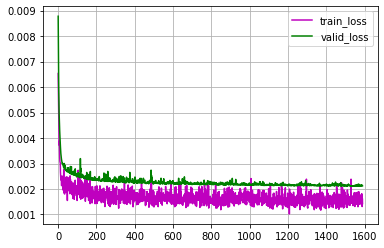

In [16]:
MAPE, MAE, RMSE, load_pred, load_true = run_model_retraining()
print('MAPE:{}, MAE:{}, RMSE:{}'.format(MAPE, MAE, RMSE))

In [20]:
print('MAPE:{}, MAE:{}, RMSE:{}'.format(MAPE, MAE, RMSE))

MAPE:0.035005764348526716, MAE:461.4167529098963, RMSE:690.913984425535


## figure plot

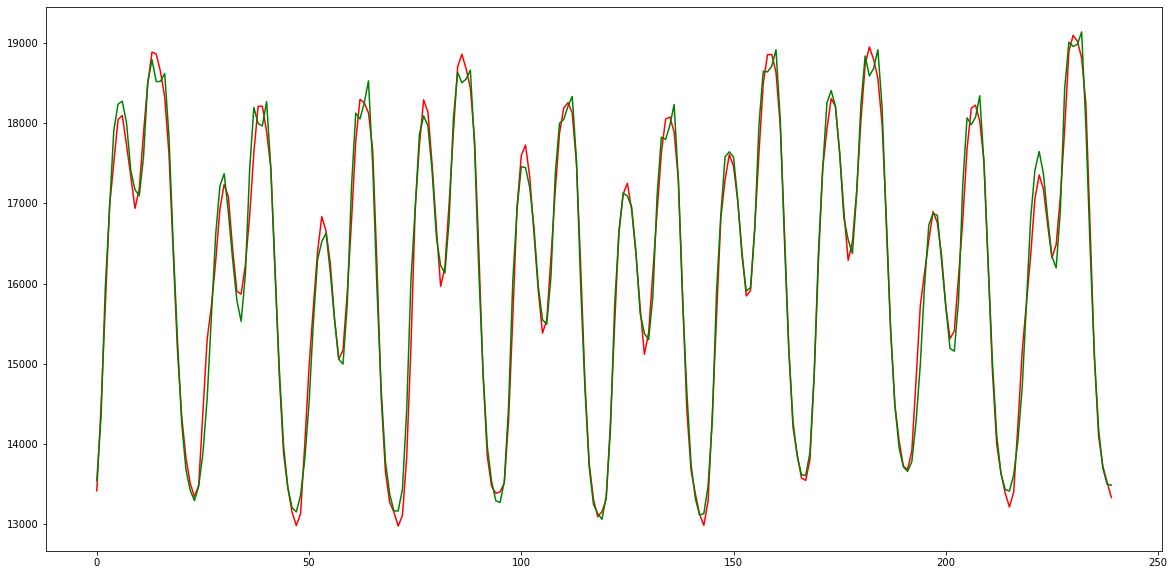

In [17]:
plt.figure(figsize=(20, 10))
load_pred = load_pred.reshape(-1, 24)
load_true = load_true.reshape(-1, 24)
plt.plot(load_pred[:240, 0], 'r')
plt.plot(load_true[:240, 0], 'g')